# TD Lambda + Tile Coding for Heartbeat prediction

Import libraries: numpy, tile_coding

tile_coding is our own library to be used as a linear approximation function.

In [2]:
import numpy as np
from tile_coding import *

## 1. TD Lambda with tile coding for nexting

* What we need more for this part

1.We need to reconsider the reward function.


2.Hyperparameters?

In [76]:
class Nexting:
    
    def __init__(self, reward_batch=1, exp_rate=0.1, lmbda=0.4, debug=True):
        self.actions = [-1, 0, 1]  # lower, 0 and upper beat
        self.state = (0,0)  # current heartbeat, predicted amount of change
        self.exp_rate = exp_rate
        self.end = False
        self.lmbda = lmbda
        self.rate_truncate = 1e-3
        self.reward_batch = reward_batch
        self.avg_pos_error = 0
        self.debug = debug
        self.step_num = 0
        
    def reset(self):
        pos = np.random.uniform(-0.3, 0.4) #?min max
        self.end = False
        self.state = (pos, 0)
        self.step_num = 0
        
    def takeAction(self, action):
        pos, gap = self.state
        
        #gap_new = gap + 0.001*action - 0.0025*np.cos(3*pos) #?
        gap_new = gap + 0.001*action
        gap_new = min(max(gap_new, GAP_BOUND[0]), GAP_BOUND[1])
        
        pos_new = pos + gap_new
        pos_new = min(max(pos_new, POSITION_BOUND[0][0]), POSITION_BOUND[0][1]) # need to change
        
        if pos_new == POSITION_BOUND[0][0]: #?
            #reach leftmost, set gap to 0
            gap_new = 0.0005 # non zero
            
        elif pos_new == POSITION_BOUND[0][1]:
            gap_new = -0.0005
             
        self.state = (pos_new, gap_new)
        
        return self.state ###
    
    def chooseAction(self, valueFunc):
         # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value(self.state, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self): # ***
        
        self.step_num += 1
        pos, _ = self.state
        true_pos = data[self.step_num]
        r_value = 0
        self.avg_pos_error = (self.avg_pos_error + (pos - true_pos))/2
        
        if self.step_num >= len(data):
            self.step_num = len(data) - 1
        
        if self.step_num % self.reward_batch == 0:
            print(self.avg_pos_error)
            if self.avg_pos_error <= 0.05 and self.avg_pos_error >= -0.05:
                r_value = 1 #0
            else:
                r_value = -1
                
            self.avg_pos_error = 0
        
        if self.step_num == len(data) - 1:
            self.end = True
        
        return r_value
    
    def gt2tn(self, valueFunc, action, end):
        # only the last reward is non-zero
        reward = self.reward
        res = reward + valueFunc.value(self.state, action)
        
        return res
        
    def play(self, valueFunction, rounds=1):
        states_per_rounds = []
        
        for rnd in range(rounds):
            self.reset()
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            
            while not self.end:
                self.state = self.takeAction(action)  # next state
                self.reward = self.giveReward()
                
                states.append(self.state)
                action = self.chooseAction(valueFunction)
                
                if self.step_num % self.reward_batch == 0:
                    if self.debug:
                        print("total states {} end at {} reward {}".format(len(states), self.state, self.reward))
                        
                    T = len(states) - 1
                    
                    for t in range(T):
                        state = states[t]
                        gtlambda = 0
                        
                        for n in range(1, T-t):
                            gttn = self.gt2tn(valueFunction, action, t+n)
                            lambda_power = np.power(self.lmbda, n-1)
                            gtlambda += lambda_power*gttn
                            
                            if lambda_power < self.rate_truncate:
                                break
                                
                        gtlambda *= 1 - self.lmbda
                        
                        if lambda_power >= self.rate_truncate:
                            gtlambda += lambda_power*self.reward
                            
                        delta = gtlambda - valueFunction.value(self.state, action)
                        valueFunction.update(self.state, action, delta)
            
            states_per_rounds.append(states)
            
        return states_per_rounds

## 2. Loading the dataset

Please run the cell below if you don't have neurokit2 and mne as your python libraries. In case you have these two, you don't need to run the cell.

In [ ]:
!pip install neurokit2
!pip install mne

In [4]:
import pandas as pd
from sklearn.preprocessing import normalize
import neurokit2 as nk
import mne
import matplotlib.pyplot as plt

In [70]:
file = "data/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

# feature range
POSITION_BOUND = [] #? range of heartbeat
for i in range(len(raw_data)):
    POSITION_BOUND.append([min(raw_data[i]), max(raw_data[i])])

Extracting EDF parameters from /Users/Textory/Desktop/Fall2022/cmput655/data/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 3. Settings to run TD lambda model for the dataset

* What we need more for this part

1.The experiment here is only for the first row of the dataset. We can use a simple loop for applying the model to our entire dataset.


2.We need to implement a progress bar of the model.


3.We need to change some hyper parameters.

In [82]:
data = raw_data[0][:20000]
GAP_BOUND = [-0.01, 0.01] #?
ACTIONS = [-1, 0, 1]
reward_batch = 300

feature_ranges = [POSITION_BOUND[0], GAP_BOUND]  # 2 features
number_tilings = 8
bins = [[100, 100] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], number_tilings), np.linspace(GAP_BOUND[0], GAP_BOUND[1], number_tilings))]

tilings = createTilings(feature_ranges, number_tilings, bins, offsets)

print("tiling shape: \n", tilings.shape)
print("offsets: \n", offsets)

valueFunc = qvalueFunction(tilings, ACTIONS, 0.3)

mc = Nexting(reward_batch=reward_batch)
predicted_states = mc.play(valueFunc, rounds=5)

tiling shape: 
 (8, 2, 99)
offsets: 
 [[-0.3326277028214003, -0.01], [-0.22827675655421997, -0.0071428571428571435], [-0.12392581028703961, -0.004285714285714286], [-0.01957486401985925, -0.0014285714285714284], [0.08477608224732108, 0.0014285714285714284], [0.18912702851450147, 0.004285714285714285], [0.2934779747816818, 0.0071428571428571435], [0.39782892104886214, 0.01]]
0.3639158418367359
total states 301 end at (0.39632892104886214, 0.0005) reward -1
0.4188167615836043
total states 601 end at (0.39482892104886214, -0.0015) reward -1
-0.059954793440879915
total states 901 end at (-0.11767107895113817, -0.01) reward -1
-0.05174008398223308
total states 1201 end at (-0.00662770282140006, 0.01) reward -1
-0.32527594108446456
total states 1501 end at (-0.3291277028214003, 0.0005) reward -1
-0.16607601269740677
total states 1801 end at (-0.16112770282140015, 0.0055000000000000005) reward -1
-0.31848690424615267
total states 2101 end at (-0.3311277028214003, 0.0005) reward -1
-0.31558513

-0.1805325299516949
total states 6601 end at (-0.17262770282140016, -0.0014999999999999996) reward -1
-0.10115774702218958
total states 6901 end at (-0.1031277028214001, 0.0035000000000000005) reward -1
-0.23752646397210092
total states 7201 end at (-0.24517107895113832, -0.006) reward -1
-0.2407194957764059
total states 7501 end at (-0.22567107895113825, -0.009000000000000001) reward -1
-0.09817633265639522
total states 7801 end at (-0.1156710789511382, 0.003) reward -1
0.17294362171879002
total states 8101 end at (0.16832892104886193, 0.003) reward -1
0.3853546612751158
total states 8401 end at (0.3673289210488621, -0.001) reward -1
-0.1479603268389476
total states 8701 end at (-0.14712770282140014, 0.0035000000000000005) reward -1
-0.12095226092322106
total states 9001 end at (-0.0931710789511382, 0.002) reward -1
0.021685424349037627
total states 9301 end at (0.0008722971785999267, 0.0085) reward 1
-0.3163580692180609
total states 9601 end at (-0.3206277028214003, 0.004500000000000

0.3938675373338456
total states 13201 end at (0.32182892104886207, -0.007500000000000001) reward -1
0.11855875463920672
total states 13501 end at (0.10382892104886188, 0.0014999999999999996) reward -1
0.03339301769169881
total states 13801 end at (0.05882892104886185, -0.0005000000000000004) reward 1
0.27956797652000737
total states 14101 end at (0.32232892104886207, 0.0004999999999999996) reward -1
0.36635967681105097
total states 14401 end at (0.34882892104886204, 0.0034999999999999996) reward -1
0.09031875711830448
total states 14701 end at (0.05182892104886183, 0.0004999999999999996) reward -1
0.4013471420273862
total states 15001 end at (0.39082892104886213, -0.0005) reward -1
0.053698307853965455
total states 15301 end at (0.06282892104886185, 0.0004999999999999996) reward -1
0.08726123509026612
total states 15601 end at (0.08882892104886188, -0.0005000000000000004) reward -1
0.059924623756572884
total states 15901 end at (0.06082892104886184, -0.0035000000000000005) reward -1
0.

0.3283899059966776
total states 19501 end at (0.33187229717860006, 0.007) reward -1
0.13333194743861393
total states 19801 end at (0.10432892104886188, -0.0055000000000000005) reward -1
0.09875001051167823
total states 301 end at (0.14087229717859992, 0.01) reward -1
-0.2999146872566215
total states 601 end at (-0.3316710789511384, -0.008) reward -1
-0.2814895102913466
total states 901 end at (-0.3321277028214003, 0.0005) reward -1
0.06913637478556095
total states 1201 end at (0.10732892104886187, 0.0024999999999999996) reward -1
-0.3249247899814548
total states 1501 end at (-0.3321277028214003, 0.0005) reward -1
-0.0490327824794184
total states 1801 end at (-0.03912770282140015, 0.01) reward 1
0.3222462352357817
total states 2101 end at (0.31637229717860005, 0.007) reward -1
-0.09300743218093774
total states 2401 end at (-0.1071277028214001, 0.003) reward -1
-0.21144172872054529
total states 2701 end at (-0.2091710789511383, -0.0005000000000000004) reward -1
-0.3055280964169866
total 

## 4. Visualisation

* What we need more for this part

1.We need to draw a graphs to compare real heartbeat / predicted heartbeat values.

### Comparing between true data and predicted results

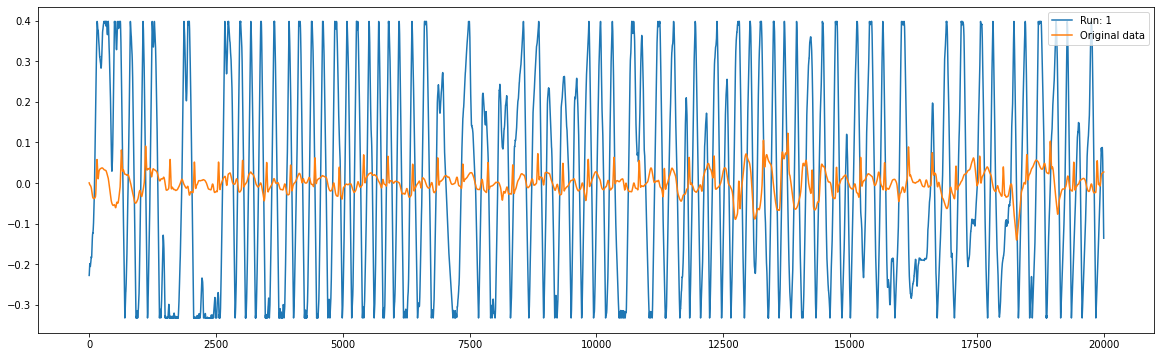

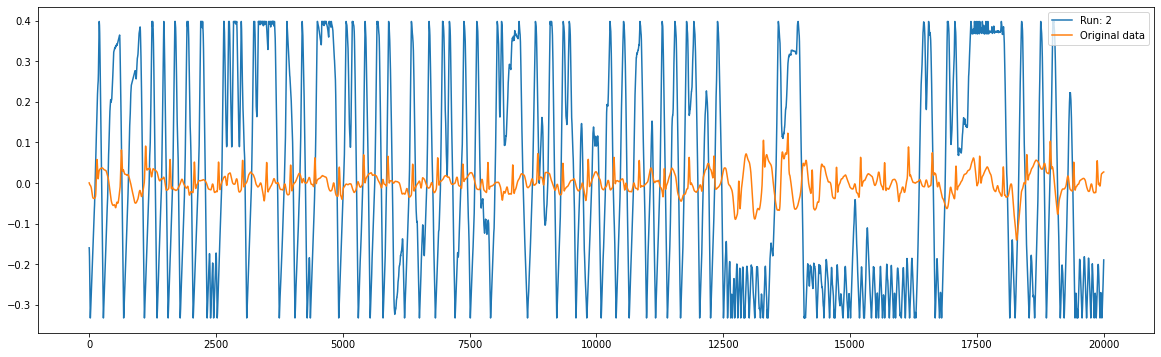

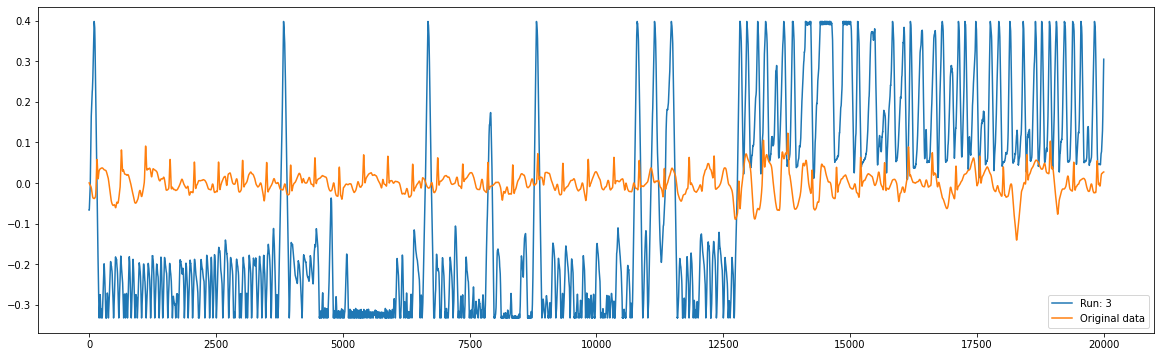

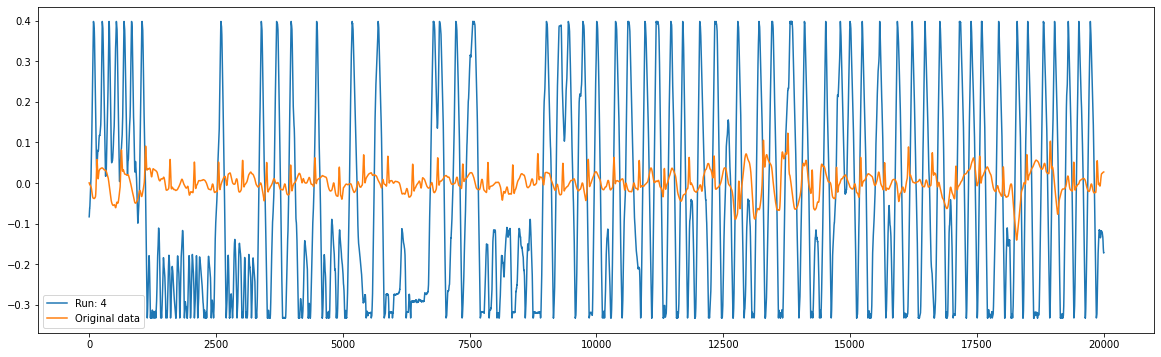

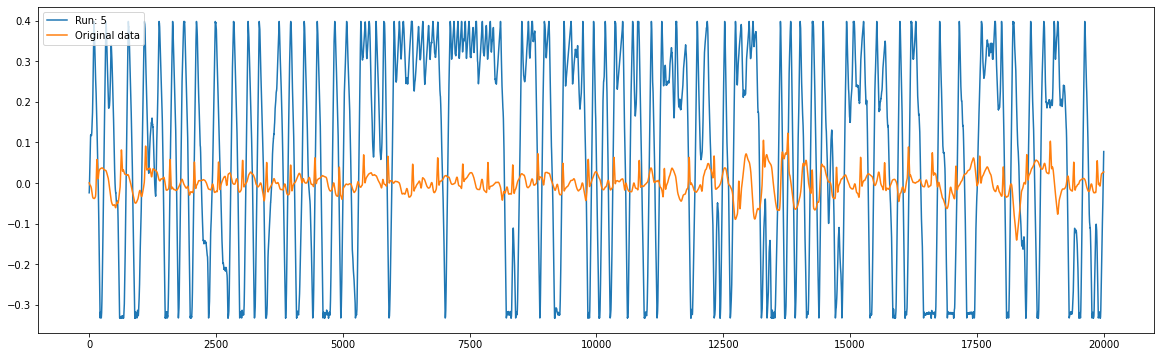

In [83]:
grids = len(data)
time_step = np.linspace(1, len(data), len(data))

predicted_positions = []


for i in range(len(predicted_states)):
    predicted_position = []
    
    for j in range(len(data)):
        predicted_position.append(predicted_states[i][j][0])
    
    predicted_positions.append(predicted_position)
    
    label = "Run: " + str(i+1)
    
    plt.figure(figsize=(20,6))    
    plt.plot(time_step, predicted_position, label = label)
    plt.plot(time_step, data, label = "Original data")
    plt.legend()
    plt.show()
    
#linestyle=":"

In [85]:
import pickle

pickle.dump(predicted_positions, open( "tdlambda_entire3000000.pickle", "wb" ) )

### RMSE Prop

In [79]:
reward_batch = 1

In [84]:
import math

start = 0
end = 0
RMSE_values = []

for pred in predicted_positions:
    start = 0
    end = 0
    RMSE_value = []
    
    for i in range(1, len(data)):
        
        if i % reward_batch == 0:
            start = end
            end = end + reward_batch
            
            true_batch = data[:end]
            predict_batch = pred[:end]
            
            MSE = np.square(np.subtract(true_batch,predict_batch)).mean()
            RMSE = math.sqrt(MSE)
            
            RMSE_value.append(RMSE)
            
    RMSE_values.append(RMSE_value)

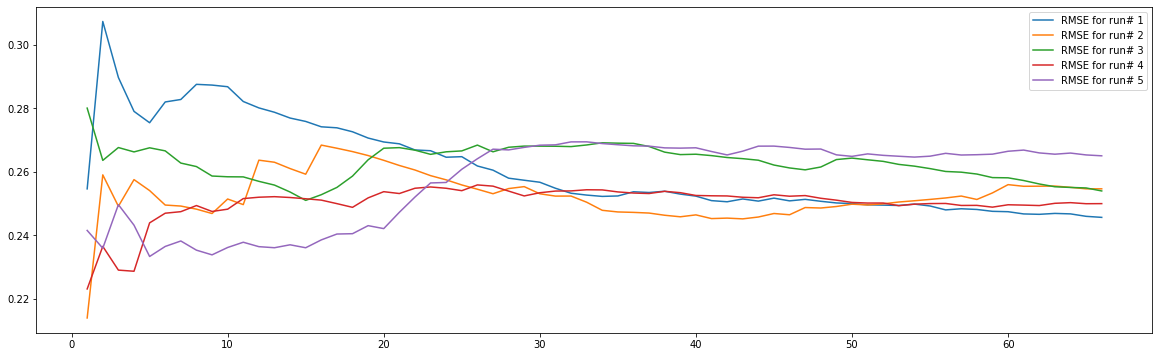

In [85]:
plt.figure(figsize=(20,6))

for i in range(len(RMSE_values)):
    
    grids = len(RMSE_values[i])
    step = np.linspace(1, len(RMSE_values[i]), len(RMSE_values[i]))
    label = "RMSE for run# " + str(i+1)
    
    plt.plot(step, RMSE_values[i], label = label)

plt.legend()
plt.show()

### Cost graph

Text(0.5, 0, 'Cost')

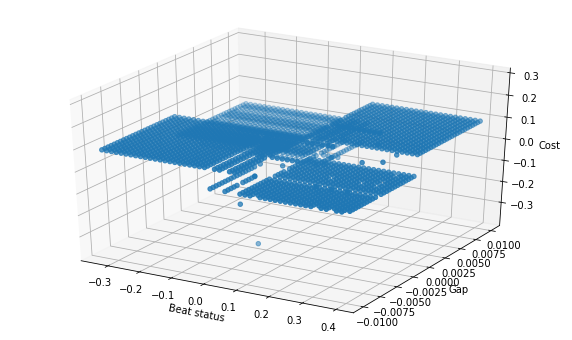

In [35]:
grids = 50

positions = np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], grids)
vels = np.linspace(GAP_BOUND[0], GAP_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.stepcost([p, v]))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Beat status")
ax.set_ylabel("Gap")
ax.set_zlabel("Cost")